---
title: "重新認識pytorch(1)"
subtitle: "從一個分類問題開始"
categories: [note,python, pytorch]
author: "紙魚"
format: html
jupyter: new_env
date: "2025-08-21"
image: "image.png"
---

為了研究 LSTM 與神經網路(neural network，以下簡稱 nn)，重新認識 pytorch 。

> 主要內容引用自 「李金洪. 2022. 全格局使用 PyTorch - 深度學習和圖神經網路 - 基礎篇. 深智數位」。

# 安裝注意事項

不同電腦適用的安裝程序不同，一定要去官網觀看，[點此](https://pytorch.org/get-started/locally/)。我的情況是 Windows + 沒有CUDA + virtualenv虛擬環境，只需要在虛擬環境中 pip install 即可。


# 從建立一個簡易的模型分析分類問題開始

本例使用模擬出的月亮資料，先生成資料，並繪圖看資料長相：

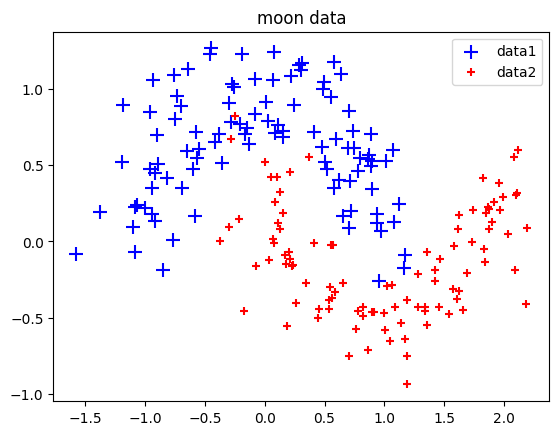

In [1]:
# import sklearn.datasets
from sklearn.datasets import make_moons
import torch
import numpy as np
import matplotlib.pyplot as plt


np.random.seed(123)
X, Y = make_moons(n_samples=200, noise=0.2) # 2組資料

arg = np.squeeze(np.argwhere(Y==0), axis=1)
arg2 = np.squeeze(np.argwhere(Y==1), axis=1)

plt.title("moon data")
plt.scatter(X[arg,0], X[arg,1],s=100, c='b',marker='+',label='data1')
plt.scatter(X[arg2,0], X[arg2,1],s=40, c='r',marker='+',label='data2')
plt.legend()
plt.show()

::: {.callout-note collapse="true"}
## code 逐列解說

```python
from sklearn.datasets import make_moons
```

 匯入 `scikit-learn` 的資料集模組中的`make_moons`，用來產生內建的資料集，例如月牙型的 `make_moons`。



```python
import torch
```

 匯入 PyTorch，用於後續的神經網路模型（尚未使用，但後面會用）。


```python
import numpy as np
```

 匯入 NumPy，進行數值與陣列操作（例如索引與隨機種子）。



```python
import matplotlib.pyplot as plt
```

 匯入 Matplotlib 的 `pyplot` 模組，用來畫圖顯示資料分佈或訓練過程。


```python
np.random.seed(0)
```

 設定 NumPy 的隨機種子，確保每次執行結果一致（資料點位置固定）。

```python
X, Y = sklearn.datasets.make_moons(200, noise=0.2)  # 2組資料
```

 產生 200 筆「moon」型資料（非線性分類資料集），加入 0.2 的隨機雜訊（增加資料真實性）。

* `X`: shape = (200, 2)，為 2D 特徵資料點。
* `Y`: shape = (200,)，標籤為 0 或 1，對應兩個半月形。



```python
arg = np.squeeze(np.argwhere(Y==0), axis=1)
```

找出所有 `Y==0` 的索引值，用於分組顯示。

* `argwhere(Y==0)` → 回傳符合條件的索引陣列（形如 (n, 1)）
* `squeeze(..., axis=1)` → 壓縮掉多餘的維度，讓 `arg` 成為 1D 陣列



```python
arg2 = np.squeeze(np.argwhere(Y==1), axis=1)
```

- 同上，找出標籤為 1 的資料索引。

```python
plt.title("moon data")
```

- 設定圖形的標題為 "moon data"


```python
plt.scatter(X[arg,0], X[arg,1], s=100, c='r', marker='+', label='data1')
```

- 畫出標籤為 0 的資料點（藍色 + 號，大小 100）。


```python
plt.scatter(X[arg2,0], X[arg2,1], s=40, c='b', marker='+', label='data2')
```

畫出標籤為 1 的資料點（紅色 + 號，大小 40）。


```python
plt.legend()
```

顯示圖例，對應 `label='data1'` 與 `label='data2'`。



```python
plt.show()
```

我們的目標是建立一個模型可以好好區分這兩組資料。

:::

## 定義模型及函數

因為只是模擬資料，我們略過區分訓練集與測試集的步驟，直接來建立模型。本次使用一個簡單的兩層nn模型`LogicNet`，這個模型可視作羅吉斯迴歸的延伸，只是多個隱藏層(hidden layer)的設定。一個 nn 模型中還會需要搭配損失函數，這裡配的是交叉熵損失函數(Cross-Entrop)用來做分類。

`LogicNet`的模型結構與數學式分別如下：

   
```scss
Input (inputdim)
    │
    ▼
Linear1 ────► [Linear Layer: inputdim → hiddendim]
    │
    ▼
Tanh ───────► [非線性(NL): tanh]
    │
    ▼
Linear2 ────► [Linear Layer: hiddendim → outputdim]
    │
    ▼
Output (logits)
```


令：

* 輸入：$\mathbf{x} \in \mathbb{R}^{\text{inputdim}}$
* 第一層(Linear1)權重、偏差：$W_1, b_1$
* 第二層(Linear2)權重、偏差：$W_2, b_2$

那模型的輸出為：

$$
\begin{aligned}
\mathbf{h} &= \tanh(W_1 \mathbf{x} + b_1) \quad \text{（隱藏層輸出）} \\
\mathbf{z} &= W_2 \mathbf{h} + b_2 \quad \text{（logits）} \\
\end{aligned}
$$

最終輸出 $\mathbf{z}$ 是 **未經 softmax 演算法 的 logits**，這是為了符合 PyTorch 的 `CrossEntropyLoss()` 要求，因為它內部會自動做 softmax。

:::{.callout-note collapse="true"}
### softmax 演算法是什麼?

softmax 本質上也屬於 activation function的一種，它能將一個含任意實數的K維向量 $z$「壓縮」到另一個K維實向量 $\sigma (z)$ ，使得每一個元素的範圍都在(0,1)之間，公式為：

$$\sigma (z)_j=\frac{e^{z_j}}{\sum _{k=1}^{K}e^{z_{jk}}}$$

[詳細可見wiki](https://en.wikipedia.org/wiki/Softmax_function)

簡單來說，softmax 算出來的東西是機率。
:::


::: {.callout-tip}
### 為什麼這裡 activation function 用 `tanh`？

* `tanh` 是一種非線性函數，將輸出壓在 $[-1, 1]$
* 適用於資料已經經過標準化（例如 `make_moons` 資料範圍在 ±1 內）
* 也可以改用更為通用的 `ReLU`，它的收斂速度通常更快。不過 `tanh` 有時在小模型且資料差異大中表現穩定。
:::

整體建立模型的流程為：

1. 定義模型的網路結構

2. 將網路結構按前向傳播(forward propagation)建立

3. 利用架設好的介面，得到模型預測結果

4. 計算模型誤差，在反向傳播(back propagation)時使用


程式部分我們建立可以控制input data 的 dimension、hidden dimension(=隱藏層數量)，output data 的 dimension等的模型函數。 code 如下，可另存 `.py`後再匯入到主程式裡：

In [2]:
import torch.nn as nn
import torch
import numpy as np
import matplotlib.pyplot as plt

class LogicNet(nn.Module): 
    def __init__(self, inputdim, hiddendim, outputdim):
        super(LogicNet,self).__init__()
        self.Linear1 = nn.Linear(inputdim,hiddendim) # 連階層
        self.Linear2 = nn.Linear(hiddendim,outputdim)
        self.criterion = nn.CrossEntropyLoss() # 定義交叉熵

    # 前向傳播
    def forward(self, x):
        x = self.Linear1(x) # 將資料傳入第一層
        x = torch.tanh(x) # 做 NL
        x = self.Linear2(x)
        return x

    def predict(self, x):
        pred = torch.softmax(self.forward(x), dim=1)
        return torch.argmax(pred,dim=1)

    # 反向傳播
    def getloss(self,x,y):
        y_pred = self.forward(x)
        loss = self.criterion(y_pred,y) # 計算loss CrossEntropy
        return loss

::: {.callout-note collapse="true"}
### 為什麼這裡所有函數都要包在 `class` 裡？
**PyTorch 中的所有神經網路模型都應繼承自 `torch.nn.Module`**。這樣做的好處是：

1. 可以自動註冊所有子層（如 `nn.Linear`）

2. 支援 `.to(device)`、`.eval()`、`.train()` 等常用方法

3. 可以很簡單地使用 PyTorch 提供的訓練工具，例如 `optimizer.step()`、`loss.backward()` 等

此外，從OOP的角度而言，把模型寫成一個class可以讓模型變成一個完整的物件，更易維護。
:::

這裡除了 activation function 外，還定義了 criterion，即 loss function。loss function是**決定模型學習品質的關鍵**，用來計算輸出值與目標值間的誤差。一般在連續的實數資料上會用 MSE ，不過在實務上會根據不同的結構、任務決定不同的 loss function ，這裡使用的是交叉熵損失函數(Cross Entropy Loss)，適用於分類問題。



## 建立模型

如前所述，我們現在來正式建立模型。因為模擬資料都是2維的，dimension = 2，隱藏層數量可以自行設定，這裡設定 3 個隱藏層：

In [3]:
model = LogicNet(inputdim=2, hiddendim=3, outputdim =2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01 )
# 印出模型資訊
print("model structure and loss function/criterion: \n")
print(model)
print("optimizer is : \n")
print(optimizer)

model structure and loss function/criterion: 

LogicNet(
  (Linear1): Linear(in_features=2, out_features=3, bias=True)
  (Linear2): Linear(in_features=3, out_features=2, bias=True)
  (criterion): CrossEntropyLoss()
)
optimizer is : 

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)


### 學習率(learning rate)

lr = 學習率(learning rate)learning rate，代表控制模型中梯度下降的速度，它決定了每次迭代的步長，使得optimizer向損失函數的最小值前進。數值越小，模型越能訓練準確，但相對應訓練較耗時。

學習率與模型權重間的關係為：

新權重= 舊權重- 學習率* 梯度 

### 最佳化器(optimizer)

在模型訓練的過程中，往往難以一次就將權重參數調整好，需要透過多次迭代，搭配好的最佳化策略才可以實現。這裡的最佳化策略就是一個演算法，也就是梯度下降法。梯度下降法有很多種，因此也是一個可以調整的參數。

在 pytorch 中，在訓練模型前需要先指定一個最佳化器物件，也就是最佳化器(optimizer)。實務上經常使用`Adam`作為最佳化器，[數學式請見此](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Adam)。`Adam`本身包含很多參數，常用的有待最佳化權重參數(固定為`model.parameters()`)及學習率。


## 訓練模型

在 pytorch 中，訓練模型前需先將資料轉成張量(Tensor)後再處理。

### 張量

張量是一種矩陣形式，可以理解成在一個大矩陣中分割出來的小矩陣。因此：

- 0 dimension 的張量 = 純量 (Scalar)
- 1 dimension 的張量 = 向量 (Vector)
- 2 dimension 的張量 = 2 $\times$ 矩陣 (2 $\times$ 2 Ｍatrix)

圖示如下：

![ ](tensor.png)

### 訓練模型與計算 loss


回到正題，接著再訓練模型與計算 loss：

In [5]:
## 訓練模型
# 轉成張量
xt = torch.from_numpy(X).type(torch.FloatTensor) # numpy to tensor
yt =  torch.from_numpy(Y).type(torch.LongTensor)
epochs = 1000 # 迭代次數
losses =[] #準備接收每一步的loss
for i in range(epochs):
    loss = model.getloss(xt,yt)
    losses.append(loss.item())
    optimizer.zero_grad() #清空之前的梯度
    loss.backward()
    optimizer.step() #更新參數

接著看看訓練結果：　

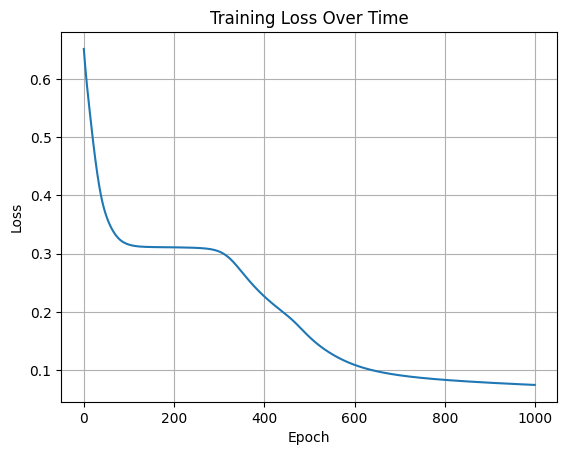

In [6]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.grid(True)
plt.show()

或者先對 loss 值做平滑處理，再視覺化，可以使某些訓練過程中產生的loss線條看起來比較平滑。這裡以moving average為例：

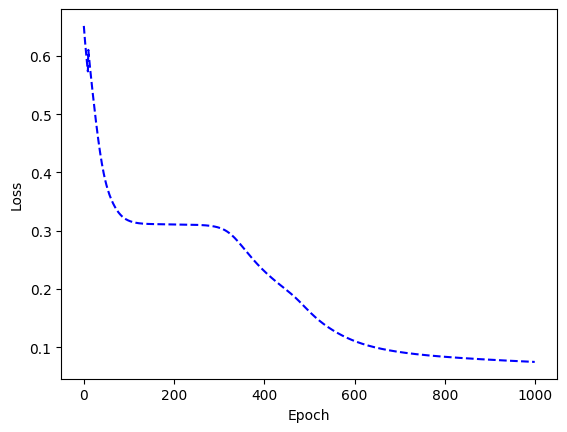

In [7]:
def moving_average(a, w=10):
    if len(a)<w:
        return a[:]
    return [val if idx < w else sum(a[(idx-w):idx])/w for idx, val in enumerate(a)]

def plot_losses(losses):
    avgloss= moving_average(losses)
    plt.figure(i)
    plt.plot(range(len(avgloss)), avgloss, 'b--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

plot_losses(losses)

## 評估模型

`accuracy_score()`是一個來自 `sklearn.metrics` 的函數，用來計算模型預測結果的 分類準確率（Accuracy），直觀理解為：模型預測正確的樣本數 / 全部樣本數。

按[klearn文件](https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score)紀錄，詳細數學定義為：

If \$\hat{y}_i$ is the predicted value of the \$i\$-th sample and $y_i$ is the corresponding true value, then the fraction of correct predictions over $n_{samples}$ samples is defined as:

$$
\text{Accuracy}(y, \hat y) = \frac{1}{n_{samples}} \sum_{i=1}^{n_{samples}-1} \mathbf{1}(\hat{y}_i = y_i)
$$

where $\mathbf{1}(\hat{y}_i = y_i)$ is the indicator function, which equals 1 if the prediction is correct, and 0 otherwise.

code實際執行起來很簡單：

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy_score:", accuracy_score(model.predict(xt),yt))

除此之外，因為本次資料dimension只有2維，可以畫決策邊界圖看看分得如何：

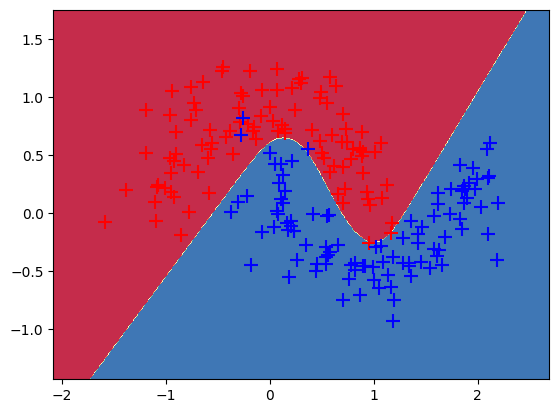

In [8]:
def predict(x):
    x = torch.from_numpy(x).type(torch.FloatTensor)
    ans=model.predict(x)
    return ans.numpy()

def plot_decision_boundary(pred_func, X, Y):
    # 計算設定值範圍
    x_min, x_max =X[:,0].min() - .5,X[:,0].max() + .5
    y_min, y_max =X[:,1].min() - .5,X[:,1].max() + .5  
    h = 0.01
    # 生成網格矩陣
    xx, yy=np.meshgrid(np.arange(x_min,x_max,h), np.arange(y_min,y_max,h))
    Z = pred_func(np.c_[xx.ravel(),yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx,yy,Z,cmap=plt.cm.Spectral)
    arg = np.squeeze(np.argwhere(Y==0),axis=1)
    arg2 = np.squeeze(np.argwhere(Y==1),axis=1)
    plt.scatter(X[arg,0],X[arg,1], s=100, c='r', marker='+')
    plt.scatter(X[arg2,0],X[arg2,1], s=100, c='b', marker='+')
    plt.show()
plot_decision_boundary(lambda x: predict(x), xt.numpy(),yt.numpy())

實際執行時，nn的 node 的初始值是隨機的，每次訓練過程都是從初始值開始調節，所以每次執行完做的模型評估結果都會有些微的不同，但`accuracy_score()`分數整體會在一個範圍浮動，差異不大。

# 補充區塊

### 學習率調整 (Learning Rates Scheduler)

學習率基本上是固定的，不過也有方法讓學習率隨迭代次數上升而變小，叫做學習率調整 (Learning Rates Scheduler)，在pytorch裡可以用 `lr_scheduler()`實現。

這裡做個示範，設定為：每50步$\times$ 0.99。

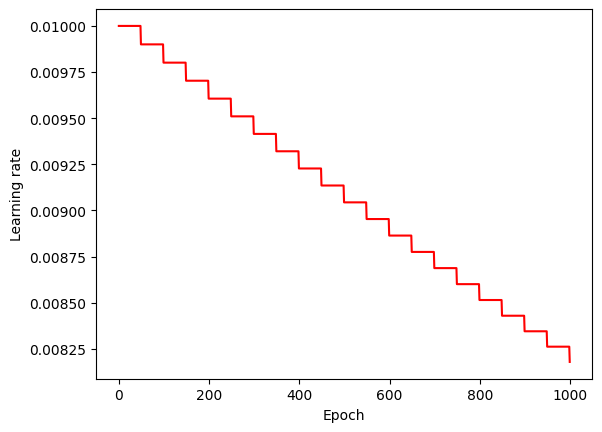

In [9]:
# record losses and lr
losses =[]
lr_list = []
epochs = 1000
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50,gamma=0.99) # 設定:每50步x0.99

for i in range(epochs):
    loss = model.getloss(xt,yt)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_list.append(lr)
plt.plot(range(epochs),lr_list,color='r')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

還有一種常用的學習率調整設定－MultiStepLR，可以設定迭代到第幾次再做調整，使得訓練起來比前一種有效率。

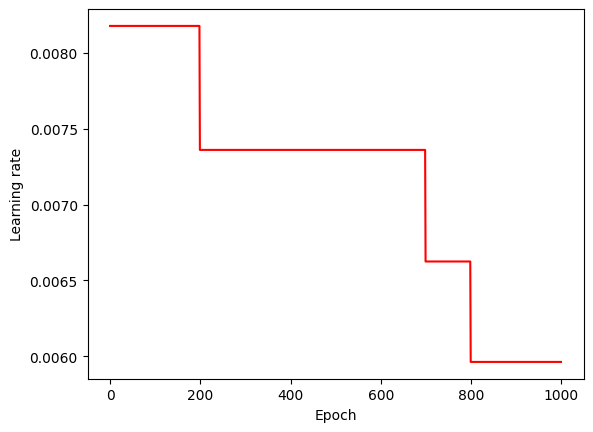

In [10]:
# record losses and lr
losses =[]
lr_list = []
epochs = 1000
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[200, 700, 800],gamma=0.9) # 設定:每50步x0.99

for i in range(epochs):
    loss = model.getloss(xt,yt)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    lr = optimizer.state_dict()['param_groups'][0]['lr']
    lr_list.append(lr)
plt.plot(range(epochs),lr_list,color='r')
plt.xlabel('Epoch')
plt.ylabel('Learning rate')
plt.show()

## 保存模型

通常一個模型需要長時間的訓練，所以 pytorch 可以保存模型，供下次進行預訓練或直接使用：

```python
torch.save(model.state_dict(),'./model.pth')
```

這個`model.pth`便是模型檔案。如要載入模型，則可以：

```python
model.load_state_dict(torch.load('./model.pth'))
```
執行後 model 中的值將跟`model.pth`同步。
